In [3]:
from gaussian_model import CenteredGM
from tqdm import tqdm
import numpy as np
import torch as tch
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from experiment_manager.explorer import get_siblings
import json
%matplotlib inline

N = 50
sigma = np.zeros((N, N))
sigma[0, N - 1] = 1
sigma[N - 1, 0] = 1
for i in range(N - 1):
    sigma[i, i + 1] = 1
    sigma[i + 1, i] = 1
model_to_fit = CenteredGM(N, precision=sigma)

def j_map(c_emp, alpha, gamma, mu=1.):
    return (alpha*c_emp + gamma*mu - np.sqrt((alpha*c_emp - gamma*mu)**2 + 4 * alpha * gamma)) / (2. * gamma)


def rho_averaging(f, alpha, gaussian_model, n_samples=10e3):
    acc = []
    N = gaussian_model.dim
    for plop in range(int(n_samples // N)):
        spectrum, _ = tch.symeig(tch.from_numpy(model_to_fit.get_empirical_C(alpha * N)), eigenvectors=False)
        acc.extend(f(spectrum.cpu().numpy()))
    return np.mean(acc)

Preparing output folders
precision matrix :  [[10.17392796  5.0616557   0.         ...  0.          0.
   5.0616557 ]
 [ 5.0616557  10.17392796  5.0616557  ...  0.          0.
   0.        ]
 [ 0.          5.0616557  10.17392796 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 10.17392796  5.0616557
   0.        ]
 [ 0.          0.          0.         ...  5.0616557  10.17392796
   5.0616557 ]
 [ 5.0616557   0.          0.         ...  0.          5.0616557
  10.17392796]] 





covariance matrix :  [[ 1.         -0.90621809  0.82149837 ... -0.74499363  0.82149837
  -0.90621809]
 [-0.90621809  1.         -0.90621809 ...  0.67593882 -0.74499363
   0.82149837]
 [ 0.82149837 -0.90621809  1.         ... -0.6136434   0.67593882
  -0.74499363]
 ...
 [-0.74499363  0.67593882 -0.6136434  ...  1.         -0.90621809
   0.82149837]
 [ 0.82149837 -0.74499363  0.67593882 ... -0.90621809  1.
  -0.90621809]
 [-0.90621809  0.82149837 -0.74499363 ...  0.82149837 -0.906

In [4]:
def solve_mu(gaussian_model, alpha, gamma, n_samples=1e4, _debug=True):
    avg = lambda func: rho_averaging(func, alpha, gaussian_model, n_samples=n_samples)
    
    # Because of the theoretical formula, we know that the mu normalization integral varies in 
    # 1 pm gamma / alpha -> impossible to solve numerically, too much uncertainty
    if gamma / alpha < 5e-2:
        return avg(lambda c: 1./c)
    
    mu_min = 0.98
    mu_max = rho_averaging(lambda C: 1./C, alpha, gaussian_model) 
    j_star = lambda C, mu: j_map(C, alpha, gamma, mu=mu)
    
    def surrogate(mu):
        plop = lambda C: 1. / (mu - j_star(C, mu))
        return 1. - avg(plop)
    
    # This to avoid issues when gamma too large, mu gets too close to 1
    if gamma / alpha > 1e2:
        try :
            roots = brentq(surrogate, mu_min, mu_max)
        except ValueError:
            return 1.
        
    # Regular pathways
    else :
        roots = brentq(surrogate, mu_min, mu_max)
    
    return roots

def plot_mu_gamma(gaussian_model, alpha, gamma_range, n_samples=1e4):
    mus = []
    for gamma in tqdm(gamma_range, leave=False):
        mus.append(solve_mu(gaussian_model, alpha, gamma))
    plt.figure()
    plt.semilogx(gamma_range, mus)
    plt.show()
    return mus

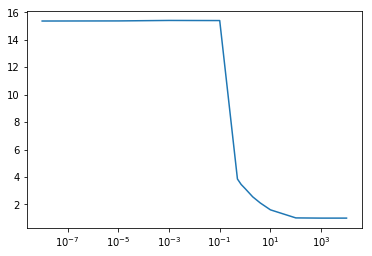

[15.378122159783828,
 15.385673500420348,
 15.42041819764033,
 15.415527622040978,
 15.411871358639422,
 3.854586532281409,
 3.4563302853925957,
 3.1579630314641776,
 2.553268537872216,
 2.101111981569589,
 1.6034849614408868,
 1.015261881336368,
 1.0000912766083494,
 1.0000013656156779]

In [3]:
plot_mu_gamma(model_to_fit, 3., [1e-8, 1e-5, 1e-3, 1e-2, 0.1, 0.5, 0.7, 1, 2., 4., 10, 100, 1000, 10000])

In [5]:
def compute_L_test(alpha, gaussian_model, j_map_func, n_samples=10e3):
    acc = []
    N = gaussian_model.dim
    ref_spectrum = tch.symeig(tch.from_numpy(model_to_fit.covariance), eigenvectors=False)[0].cpu().numpy()

    for plop in range(int(n_samples // N)):
        spectrum, _ = tch.symeig(tch.from_numpy(model_to_fit.get_empirical_C(alpha * N)), eigenvectors=False)
        acc.extend(j_map_func(spectrum.cpu().numpy()) * ref_spectrum)
    return np.mean(acc)

def compute_likelihoods(gaussian_model, alpha, gamma, n_samples=10e3, _debug=False):
    # Seems like the issue is coming from Q2 -> if we hardcode it to the experimental value, 
    # everything works fine
    N = gaussian_model.dim
    mu = solve_mu(gaussian_model, alpha, gamma, _debug=_debug)
    
    j_star = lambda C: j_map(C, alpha, gamma, mu=mu)
    avg = lambda func: rho_averaging(func, alpha, gaussian_model, n_samples=n_samples)
    
    c_times_jc = lambda C: C * j_star(C)
    jc_square = lambda C: j_star(C) * j_star(C)
    log_mu_minus_j = lambda C: np.log(mu - j_star(C))
    
    # This seems to be true
    logZ = N / 2. * (mu - avg(log_mu_minus_j))
    
    # Not this
    q2 = avg(jc_square) * N / 2.

    # this would be true exccept for fucking Q2
    L_test = N / 2. * compute_L_test(alpha, gaussian_model, j_star) 
    L_train = N / 2. * avg(c_times_jc)
    L_gen = L_train - (gamma/alpha) * q2 
    
    if _debug:
        print('mu = {}'.format(mu))
        print('logZ = {}'.format(logZ))
        print('Ltrain {}, q2 {}, Lgen {}'.format(L_train, q2, L_gen))
    
    return L_train, L_test, L_gen, logZ, q2
    

In [6]:
def plot_likelihoods(n_samples=1e5, path='out_bidiag/', base_exp='23e22032399e1336', n_l=0, n_r=0):
    siblings, values = get_siblings(base_exp, 'gamma', path=path)
    plop = len(values)
    siblings, values = siblings[n_l:plop-n_r], values[n_l:plop-n_r]

#     gamma_min, gamma_max = values[0], values[-1]
#     gamma_range = np.exp(np.linspace(np.log(gamma_min), np.log(gamma_max), 20.))
    
    with open(path+'raw/{}/params'.format(base_exp), 'r') as f:
        alpha = json.load(f)['alpha']
    
    gamma_values = values
    
    th_acc = np.zeros((5, len(gamma_values)))
    
    L_train_mean = np.zeros(len(gamma_values))
    L_train_std = np.zeros(len(gamma_values))
    
    L_test_mean = np.zeros(len(gamma_values))
    L_test_std = np.zeros(len(gamma_values))
    
    L_gen_mean = np.zeros(len(gamma_values))
    L_gen_std = np.zeros(len(gamma_values))
    
    logZ_mean = np.zeros(len(gamma_values))
    logZ_mean_th = np.zeros(len(gamma_values))
    
    Q2_mean = np.zeros(len(gamma_values))
    Q2_std = np.zeros(len(gamma_values))
    
    for idx, gamma in enumerate(tqdm(gamma_values)):
        L_train_mean[idx] = np.load(path+'raw/{}/L_train.npy'.format(siblings[idx]))[:, -100:].mean()
        L_train_std[idx] = np.load(path+'raw/{}/L_train.npy'.format(siblings[idx]))[:, -100:].std()
        
        L_test_mean[idx] = np.load(path+'raw/{}/L_test.npy'.format(siblings[idx]))[:, -100:].mean()
        L_test_std[idx] = np.load(path+'raw/{}/L_test.npy'.format(siblings[idx]))[:, -100:].std()
        
        L_gen_mean[idx] = np.load(path+'raw/{}/L_gen.npy'.format(siblings[idx]))[:, -100:].mean()
        L_gen_std[idx] = np.load(path+'raw/{}/L_gen.npy'.format(siblings[idx]))[:, -100:].std()
        
        logZ_mean[idx] = np.load(path+'raw/{}/logZ.npy'.format(siblings[idx]))[:, -100:].mean()
        
        Q2_mean[idx] = np.load(path+'raw/{}/Q2.npy'.format(siblings[idx]))[:, -100:].mean()
        Q2_std[idx] = np.load(path+'raw/{}/Q2.npy'.format(siblings[idx]))[:, -100:].std()
        
        th_acc[:, idx] = np.array(compute_likelihoods(model_to_fit, alpha, gamma, n_samples=n_samples, _debug=True))
        logZ_mean_th[idx] = th_acc[3, idx]
        

    
    lims = [np.min([np.min(th_acc[0, :] - th_acc[3, :]), np.min(th_acc[1, :] - th_acc[3, :]), np.min(th_acc[2, :] - th_acc[3, :])]),
           np.max([np.max(th_acc[0, :] - th_acc[3, :]), np.max(th_acc[1, :] - th_acc[3, :]), np.max(th_acc[2, :] - th_acc[3, :])])]
    
    lims = 1.3 * np.array(lims)
    
    
    plt.figure()
    plt.title(r'Likelihoods as a function of $\gamma$ for $alpha$={}'.format(alpha))
    plt.plot(gamma_values, th_acc[0, :] - th_acc[3, :], c='b', label=r'$L^{train} th$')
    plt.plot(gamma_values, th_acc[1, :] - th_acc[3, :], c='r', label=r'$L^{test} th$')
    plt.plot(gamma_values, th_acc[2, :] - th_acc[3, :], c='g', label=r'$L^{gen}th$')
    plt.errorbar(gamma_values, np.clip(L_train_mean - logZ_mean_th, *lims), yerr=L_train_std, fmt='o', c='b', label=r'$L^{train} exp$')
    plt.errorbar(gamma_values, np.clip(L_test_mean - logZ_mean_th, *lims), yerr=L_test_std, fmt='o', c='r', label=r'$L^{test} exp$')
    plt.errorbar(gamma_values, np.clip(L_gen_mean - logZ_mean_th, *lims), yerr=L_gen_std, fmt='o', c='g', label=r'$L^{gen} exp$')
    plt.xlabel(r'Regularization $\gamma$')
    plt.ylabel('Log likelihoods')
    plt.xscale('log')
    plt.ylim(lims)
    plt.legend(loc='best')
    plt.show()
    
    print(L_train_mean - logZ_mean_th, L_test_mean - logZ_mean_th, L_gen_mean - logZ_mean_th)
    print(th_acc[0, :] - th_acc[3, :], th_acc[1, :] - th_acc[3, :], th_acc[2, :] - th_acc[3, :])
    
    plt.figure()
    plt.title(r'Q2 as a function of $\gamma$ for $alpha$={}'.format(alpha))
    plt.errorbar(gamma_values, Q2_mean, yerr=Q2_std, fmt='o', c='b', label=r'$Q2 exp$')
    plt.plot(gamma_values, th_acc[-1])
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    
    
    plt.figure()
    plt.plot(gamma_values, (th_acc[2, :]-th_acc[1, :]) / (th_acc[0, :]-th_acc[1, :]), c='b', label=r'$\frac{L^{gen}-L^{test}}{L^{train}-L^{test}}$')
#     plt.plot(gamma_values, (L_gen_mean - L_test_mean))
    plt.xlabel(r'Regularization $\gamma$')
    plt.ylabel('Likelihood ratio')
    plt.xscale('log')
    plt.legend(loc='best')
    plt.show()
    

  0%|          | 0/17 [00:00<?, ?it/s]

To vary parameter gamma in [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 3.e-01 7.e-01 1.e+00
 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07], visit ['6b8f88f2552a1bb3' 'd0288d6fab5586cd' '23e22032399e1336'
 'e0a855415d63c453' '4a57676558ec098b' '3c19b8c43e005077'
 'b0cd83158b28861f' '78ab226bb5063c07' '01835c26d372ce1c'
 '40f52006a16183cd' 'c14e7f3aaa7f1818' '952563c3149563e9'
 '738468ba294108e9' '4501081cfcd562c3' '364b9bc07a0651fc'
 'ab0d01aecaf3c0eb' '01fee0fbe0cab64d']


  6%|▌         | 1/17 [00:12<03:20, 12.53s/it]

mu = 15.422627172868042
logZ = 337.7005920394131
Ltrain 361.3141973574152, q2 6071.0823125413135, Lgen 361.31399498800477


 12%|█▏        | 2/17 [00:24<03:05, 12.39s/it]

mu = 15.403492686210933
logZ = 337.214265445217
Ltrain 359.37811166486836, q2 6052.072608843221, Lgen 359.3760943073321


 18%|█▊        | 3/17 [00:37<02:55, 12.50s/it]

mu = 15.389553930350111
logZ = 336.8913610529121
Ltrain 359.0884973073699, q2 5991.419687807827, Lgen 359.06852590841055


 24%|██▎       | 4/17 [00:49<02:41, 12.42s/it]

mu = 15.401213258547429
logZ = 337.3375828302854
Ltrain 360.64898944361994, q2 5429.310280831398, Lgen 360.46801243425887


 29%|██▉       | 5/17 [01:02<02:29, 12.46s/it]

mu = 15.406699233321863
logZ = 338.3768158584417
Ltrain 361.4977227402614, q2 3521.1964864815454, Lgen 360.3239905781009


 35%|███▌      | 6/17 [01:15<02:19, 12.65s/it]

mu = 15.428559408281302
logZ = 340.0422306055159
Ltrain 361.84262405718977, q2 1932.330674606599, Lgen 355.4015218085011


 41%|████      | 7/17 [01:27<02:05, 12.60s/it]

mu = 15.375517159169366
logZ = 333.806023376331
Ltrain 350.98484625486157, q2 1135.8684540949826, Lgen 313.1225644516955


 47%|████▋     | 8/17 [01:52<02:25, 16.15s/it]

mu = 4.36676225825261
logZ = 79.41956230133985
Ltrain 92.89755210490719, q2 86.08653757385837, Lgen 84.28889834752135


 53%|█████▎    | 9/17 [02:19<02:35, 19.49s/it]

mu = 3.458551199888291
logZ = 61.165362168090034
Ltrain 71.23668066880985, q2 41.838479606335824, Lgen 61.47436876066483


 59%|█████▉    | 10/17 [02:46<02:32, 21.77s/it]

mu = 3.159931710502209
logZ = 55.48327673692954
Ltrain 64.14725673565661, q2 31.05036844149313, Lgen 53.79713392182557


 65%|██████▍   | 11/17 [03:15<02:24, 24.03s/it]

mu = 1.5996659099878976
logZ = 30.366857498128823
Ltrain 26.82327319160775, q2 3.5811553115574517, Lgen 14.886088819749578


 71%|███████   | 12/17 [03:35<01:53, 22.74s/it]

mu = 1.0147742524410042
logZ = 25.147858826443713
Ltrain 7.065884384099305, q2 0.20186099094765572, Lgen 0.33718468584411365


 76%|███████▋  | 13/17 [03:58<01:30, 22.68s/it]

mu = 1.0000982522033421
logZ = 25.00109768137039
Ltrain 0.7490233592321728, q2 0.0022501986863770027, Lgen -0.001042869560161419


 82%|████████▏ | 14/17 [04:18<01:05, 21.88s/it]

mu = 0.9999993171291975
logZ = 25.000010046344446
Ltrain 0.07464569427836351, q2 2.243514490795531e-05, Lgen -0.00013812208148752947


 88%|████████▊ | 15/17 [04:38<00:42, 21.46s/it]

mu = 1.0000000635964967
logZ = 25.000000697296677
Ltrain 0.007453241179620095, q2 2.2463238940158063e-07, Lgen -3.4505133765926066e-05


 94%|█████████▍| 16/17 [05:00<00:21, 21.55s/it]

mu = 0.9999999978225066
logZ = 25.000000127032106
Ltrain 0.0007481592487003342, q2 2.2537587619724206e-09, Lgen -3.093671957139256e-06


100%|██████████| 17/17 [05:20<00:00, 20.99s/it]

mu = 1.0000000005104719
logZ = 25.000000010814034
Ltrain 7.463345946125725e-05, q2 2.242281436145672e-11, Lgen -1.0925507693182099e-07


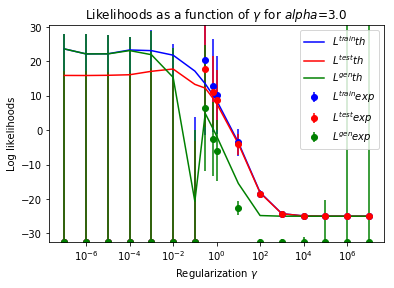

[-135.38013033 -134.96059279 -135.04964001 -135.48219421 -136.70420154
 -148.46210658 -194.93828881   20.36804653   12.90870819   10.28184409
   -3.55580755  -18.51671929  -24.262141    -24.91674641  -24.98604819
  -25.00302788  -24.99910429] [-141.78147739 -141.34049267 -141.51275456 -141.77744028 -143.11731592
 -154.37620624 -198.7218545    17.84562405   11.1972486     8.79676634
   -4.13594867  -18.61490393  -24.27575171  -24.91988163  -24.98613763
  -25.00460345  -24.99834287] [-1.35380161e+02 -1.34960894e+02 -1.35052631e+02 -1.35512401e+02
 -1.37004265e+02 -1.51062659e+02 -2.06101212e+02  6.33109207e+00
 -2.47991602e+00 -5.98289764e+00 -2.25586808e+01 -3.25354994e+01
 -3.32877688e+01 -3.89149842e+01 -1.28057796e+02 -1.07976148e+03
 -1.05912320e+04]
[ 23.61360532  22.16384622  22.19713625  23.31140661  23.12090688
  21.80039345  17.17882288  13.4779898   10.0713185    8.66398
  -3.54358431 -18.08197444 -24.25207432 -24.92536435 -24.99254746
 -24.99925197 -24.99992538] [ 15.91056408

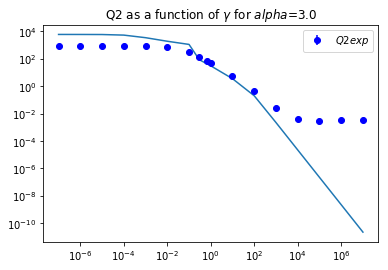

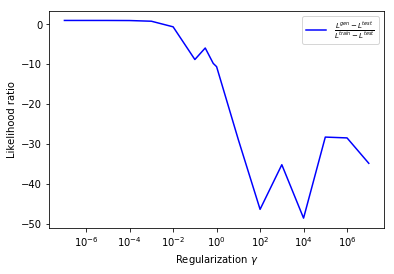

In [7]:
plot_likelihoods(n_l=0, n_r=0)

  0%|          | 0/17 [00:00<?, ?it/s]

To vary parameter gamma in [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 3.e-01 7.e-01 1.e+00
 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07], visit ['3cd7e36741af1977' '4e3bdefbe6077f0b' '1d68cb23831db600'
 '6f99e408be723a63' 'e64bc954342a0ba2' '1d12e0b1954ef60a'
 'f10f68f932c4c711' '7726e93c16cdba86' 'fe912345062f48a5'
 '10cf9482fe70cf18' 'e5e97f25f949049b' '632755cd9a966c7a'
 'abbfac1eced955cf' '85fa9ea7b65ad97b' '048426a088a62f43'
 '902b9080c43f4b50' 'ff3fe79eb525adce']


  6%|▌         | 1/17 [00:21<05:41, 21.33s/it]

mu = 11.350776337861197
logZ = 239.42090938383691
Ltrain 258.9851801324592, q2 1959.7893001870527, Lgen 258.9851605345662


 12%|█▏        | 2/17 [00:41<05:14, 20.94s/it]

mu = 11.305984950425803
logZ = 238.28600103621608
Ltrain 257.80050453343136, q2 1958.6328490880824, Lgen 257.8003086701465


 18%|█▊        | 3/17 [01:02<04:55, 21.10s/it]

mu = 11.31813357940154
logZ = 238.60077510377008
Ltrain 258.31471348210164, q2 1954.7508658068323, Lgen 258.3127587312358


 24%|██▎       | 4/17 [01:22<04:30, 20.81s/it]

mu = 11.323178759832475
logZ = 238.7509216301643
Ltrain 258.2881546822227, q2 1942.0489834908558, Lgen 258.2687341923878


 29%|██▉       | 5/17 [01:43<04:07, 20.59s/it]

mu = 11.329598994248098
logZ = 239.0526279817315
Ltrain 258.1954525125817, q2 1831.8797292437164, Lgen 258.01226453965734


 35%|███▌      | 6/17 [02:03<03:45, 20.46s/it]

mu = 11.330919375092785
logZ = 240.04727519304677
Ltrain 259.2368682439715, q2 1330.1348637287635, Lgen 257.90673338024277


 41%|████      | 7/17 [02:23<03:25, 20.52s/it]

mu = 11.338216352189187
logZ = 241.1311589953983
Ltrain 259.41298761091474, q2 806.3742335096752, Lgen 251.349245275818


 47%|████▋     | 8/17 [02:43<03:03, 20.39s/it]

mu = 11.328558381363544
logZ = 239.30426921449586
Ltrain 256.2218679758048, q2 639.0330531607872, Lgen 237.05087638098118


 53%|█████▎    | 9/17 [03:34<03:56, 29.55s/it]

mu = 4.69686042782153
logZ = 86.45420179632639
Ltrain 100.00674974349515, q2 108.16012841206326, Lgen 92.43554075465072


 59%|█████▉    | 10/17 [04:18<03:56, 33.76s/it]

mu = 4.316623126412633
logZ = 78.53238495351599
Ltrain 90.95938736558506, q2 82.19943300440205, Lgen 82.73944406514485


 65%|██████▍   | 11/17 [04:59<03:34, 35.83s/it]

mu = 2.2479556982216984
logZ = 39.52673181415531
Ltrain 42.21791347735066, q2 11.034894464813519, Lgen 31.183019012537144


 71%|███████   | 12/17 [05:36<03:01, 36.26s/it]

mu = 1.1999912293709132
logZ = 26.413978936888867
Ltrain 15.799983666468473, q2 1.0784894353876835, Lgen 5.015089312591638


 76%|███████▋  | 13/17 [06:15<02:28, 37.17s/it]

mu = 1.0011288216888063
logZ = 25.01341850489831
Ltrain 2.38743867699927, q2 0.023668321020860084, Lgen 0.020606574913261344


 82%|████████▏ | 14/17 [06:52<01:50, 36.98s/it]

mu = 1.0000101466787694
logZ = 25.00011886303448
Ltrain 0.24252513268876738, q2 0.00024222831582898594, Lgen 0.0002968168597814458


 88%|████████▊ | 15/17 [07:25<01:11, 35.97s/it]

mu = 0.9999999208489098
logZ = 24.99999919556991
Ltrain 0.02426844813596725, q2 2.419607691978939e-06, Lgen 7.23712161778585e-05


 94%|█████████▍| 16/17 [07:57<00:34, 34.56s/it]

mu = 1.000000003970007
logZ = 24.999999984198176
Ltrain 0.002432541741434288, q2 2.4151366755664188e-08, Lgen 1.740506586786917e-05


100%|██████████| 17/17 [08:26<00:00, 32.87s/it]

mu = 1.0000000005839909
logZ = 25.000000030237924
Ltrain 0.0002420262444882849, q2 2.4151523787080505e-10, Lgen 5.110066174798345e-07


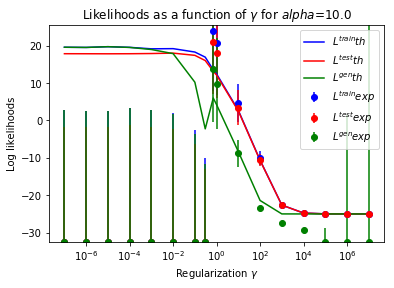

[-46.24621929 -44.96176399 -46.10374599 -45.08252895 -46.23302893
 -50.1599726  -71.46213069 -99.78290417  23.8702696   20.59908369
   4.70369852 -10.05400684 -22.50698245 -24.747594   -24.98280443
 -25.0000286  -25.00058927] [ -51.64459038  -50.37014519  -51.50369352  -50.52604774  -51.64385992
  -55.45420795  -76.10899993 -103.54989956   20.95099951   17.97375757
    3.45572094  -10.58121832  -22.59244145  -24.75640698  -24.98255224
  -25.00019639  -25.00139007] [  -46.24622307   -44.96182793   -46.10437967   -45.08889427
   -46.29606058   -50.76584865   -75.94278085  -107.78365149
    13.86965978     9.86978429    -8.77415161   -23.39128451
   -27.48433173   -29.25814865   -56.09435817  -333.76894076
 -3115.22419101]
[ 19.56427075  19.5145035   19.71393838  19.53723305  19.14282453
  19.18959305  18.28182862  16.91759876  13.55254795  12.42700241
   2.69118166 -10.61399527 -22.62597983 -24.75759373 -24.97573075
 -24.99756744 -24.999758  ] [ 17.8350819   17.82597991  17.81265413  17.

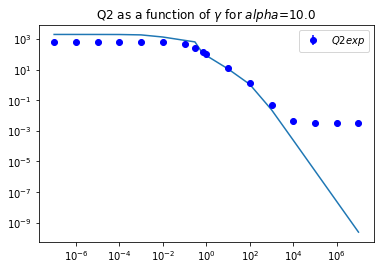

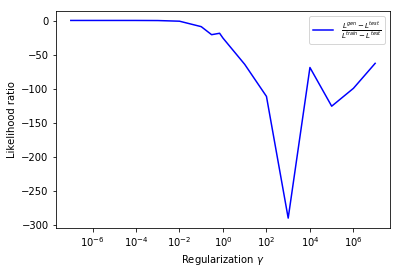

In [8]:
plot_likelihoods(base_exp='e5e97f25f949049b', n_l=0, n_r=0)

  0%|          | 0/17 [00:00<?, ?it/s]

To vary parameter gamma in [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 3.e-01 7.e-01 1.e+00
 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07], visit ['bfa019f0cd920841' 'fe93592cba2610fb' '1eeb2263ffcfd24c'
 'c8f289763b830973' '618f7d4bdc8335c5' '03e6672b7a06b299'
 'b1f02f7329e72ad5' '762a87ccd8d70e8f' '8116c47e2159e291'
 'dce4a5897aac157f' 'e4b1122605c37c42' '4491a251718f6a28'
 '2c275ac2e9ed7d4e' '35097bc7c4025ec3' 'a60d9cefa7f14a2c'
 '43ecf3a05c531050' 'ab56d0c0649927e3']


  6%|▌         | 1/17 [00:30<08:08, 30.50s/it]

mu = 10.7146464942563
logZ = 224.1910229187246
Ltrain 242.76169988020436, q2 1578.6552617657042, Lgen 242.76169198692804


 12%|█▏        | 2/17 [01:00<07:33, 30.26s/it]

mu = 10.718211938075674
logZ = 224.27662902502755
Ltrain 242.97452005458905, q2 1577.379097874326, Lgen 242.97444118563416


 18%|█▊        | 3/17 [01:28<06:57, 29.79s/it]

mu = 10.716960157775913
logZ = 224.24063802366638
Ltrain 242.86874369566877, q2 1578.4644313091158, Lgen 242.86795446345312


 24%|██▎       | 4/17 [01:57<06:23, 29.51s/it]

mu = 10.715117467099367
logZ = 224.20006080855165
Ltrain 242.80273474754915, q2 1574.1106656208506, Lgen 242.79486419422105


 29%|██▉       | 5/17 [02:26<05:51, 29.28s/it]

mu = 10.709885447975541
logZ = 224.14593176632613
Ltrain 242.81941698248488, q2 1540.1555416274389, Lgen 242.7424092054035


 35%|███▌      | 6/17 [02:57<05:27, 29.74s/it]

mu = 10.719042527569773
logZ = 224.901562873124
Ltrain 243.57417977465258, q2 1303.3567267436333, Lgen 242.92250141128076


 41%|████      | 7/17 [03:27<04:58, 29.89s/it]

mu = 10.71444650876409
logZ = 226.242223387494
Ltrain 244.49256849725606, q2 819.1731180481828, Lgen 240.39670290701514


 47%|████▋     | 8/17 [03:57<04:28, 29.85s/it]

mu = 10.730818615439581
logZ = 226.4335662065298
Ltrain 243.9190796076032, q2 661.8777846075353, Lgen 233.99091283849017


 53%|█████▎    | 9/17 [04:27<03:58, 29.81s/it]

mu = 10.725533823114434
logZ = 224.9097282442711
Ltrain 240.97942020602642, q2 550.3329785175854, Lgen 221.71776595791093


 59%|█████▉    | 10/17 [05:24<04:26, 38.08s/it]

mu = 5.1003991810317295
logZ = 95.12307081310303
Ltrain 109.33298143438944, q2 138.3674212503605, Lgen 102.41461037187142


 65%|██████▍   | 11/17 [06:25<04:30, 45.05s/it]

mu = 2.7372360727876406
logZ = 47.785238541626754
Ltrain 53.699963567196306, q2 20.561341666293412, Lgen 43.4192927340496


 71%|███████   | 12/17 [07:17<03:55, 47.07s/it]

mu = 1.417461473308368
logZ = 28.36339197209896
Ltrain 22.032656674170376, q2 2.3242630934877813, Lgen 10.41134120673147


 76%|███████▋  | 13/17 [08:01<03:04, 46.02s/it]

mu = 1.005286348724827
logZ = 25.057262439946786
Ltrain 4.679393828254681, q2 0.09103389185435831, Lgen 0.127699235536765


 82%|████████▏ | 14/17 [08:49<02:20, 46.79s/it]

mu = 1.0000378318870045
logZ = 25.000508858558522
Ltrain 0.4798686869201212, q2 0.0009614607881159043, Lgen -0.0008617071378309582


 88%|████████▊ | 15/17 [09:39<01:35, 47.67s/it]

mu = 1.0000004564214313
logZ = 25.00000269829102
Ltrain 0.047948767032597, q2 9.615455621227846e-06, Lgen -0.00012851107354223262


 94%|█████████▍| 16/17 [10:30<00:48, 48.62s/it]

mu = 1.0000000148855084
logZ = 24.99999962351574
Ltrain 0.004815990081802944, q2 9.617928455098771e-08, Lgen 7.025854253558429e-06


100%|██████████| 17/17 [11:15<00:00, 47.64s/it]

mu = 1.00000000042654
logZ = 25.000000021436396
Ltrain 0.0004802450784194963, q2 9.637157079414152e-10, Lgen -1.612775551211316e-06


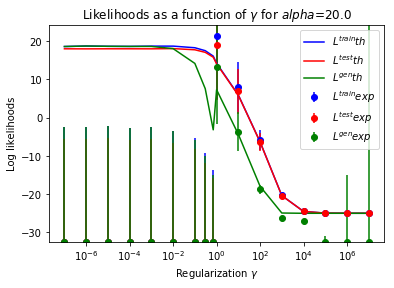

[-48.15907918 -48.24468528 -47.92259683 -47.230593   -48.28553407
 -49.91004132 -60.55905068 -77.10704099 -97.57980571  21.21520655
   7.96454294  -5.86752075 -20.24194608 -24.4944938  -24.9571168
 -24.9887273  -24.98301814] [-51.53683808 -51.62244419 -51.29952036 -50.60634876 -51.65061026
 -53.2389441  -63.68077241 -79.89631266 -99.93823203  19.07426542
   6.91526435  -6.34650129 -20.35704312 -24.50674388 -24.95934728
 -24.98876889 -24.98441504] [  -48.15907918   -48.24470915   -47.92284008   -47.23304487
   -48.30959109   -50.14987666   -62.62645383   -81.80442479
  -104.82557446    13.10598596    -3.64271992   -18.74524804
   -26.13069977   -27.0818377    -40.36771357  -171.58095529
 -1551.44685107]
[ 18.57067696  18.69789103  18.62810567  18.60267394  18.67348522
  18.6726169   18.25034511  17.4855134   16.06969196  14.20991062
   5.91472503  -6.3307353  -20.37786861 -24.52064017 -24.95205393
 -24.99518363 -24.99951978] [ 17.97211887  17.95852215  17.97834342  17.97712875  17.96720

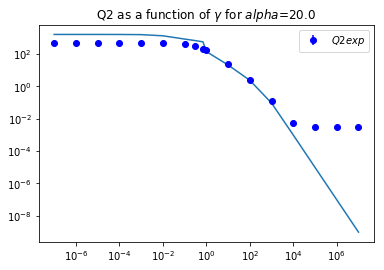

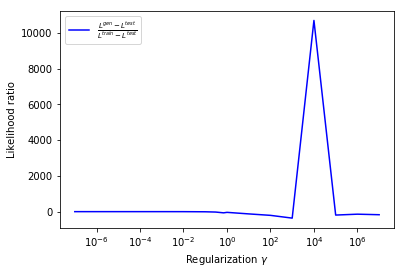

In [9]:
plot_likelihoods(base_exp='4491a251718f6a28', n_l=0, n_r=0)

  0%|          | 0/17 [00:00<?, ?it/s]

To vary parameter gamma in [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 3.e-01 7.e-01 1.e+00
 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07], visit ['1863b4bf2a757419' '3ea67eb68451c5d6' 'f2c5d28de9f9ab63'
 'aeb482616e697bc6' '670e5f3638e26339' '5d2b20b7a6a0c49e'
 '422eca2201340a0a' 'c59772b5cc8759b6' 'b1d15ef1b6f53c9e'
 '9b2857df278606a9' '81382151f799f093' 'c29f0d2995d8b769'
 '21ec5ca199e23954' '39eaddb08fbb7fe0' '85936fe1c21ae59e'
 '1a8363609b8d8d01' '176492489e216d96']


  6%|▌         | 1/17 [01:51<29:50, 111.93s/it]

mu = 10.281201199035287
logZ = 213.86910362927392
Ltrain 232.06687791222814, q2 1335.0157012148404, Lgen 232.06687657721244


 12%|█▏        | 2/17 [03:43<27:57, 111.81s/it]

mu = 10.278096802825281
logZ = 213.78982971004845
Ltrain 231.8931002624031, q2 1335.3093530230333, Lgen 231.89308690930957


 18%|█▊        | 3/17 [05:36<26:09, 112.10s/it]

mu = 10.277282570408216
logZ = 213.76918894052767
Ltrain 231.85790686253566, q2 1334.617353990994, Lgen 231.85777340080026


 24%|██▎       | 4/17 [07:31<24:31, 113.19s/it]

mu = 10.277966008553314
logZ = 213.78763408232086
Ltrain 232.01303923561832, q2 1333.9959014024018, Lgen 232.01170523971692


 29%|██▉       | 5/17 [09:24<22:36, 113.01s/it]

mu = 10.280243532410848
logZ = 213.85778957217934
Ltrain 232.06789012794346, q2 1330.3408668362854, Lgen 232.0545867192751


 35%|███▌      | 6/17 [11:20<20:51, 113.82s/it]

mu = 10.281861169485026
logZ = 214.013760617748
Ltrain 232.17149409990446, q2 1286.7281328728782, Lgen 232.04282128661717


 41%|████      | 7/17 [13:14<18:59, 113.91s/it]

mu = 10.279496687098995
logZ = 214.73021767027828
Ltrain 232.71317599513375, q2 1034.3740608442663, Lgen 231.67880193428948


 47%|████▋     | 8/17 [15:05<16:57, 113.06s/it]

mu = 10.277122896779222
logZ = 215.4521858214852
Ltrain 233.3455035712278, q2 831.8364555745447, Lgen 230.84999420450416


 53%|█████▎    | 9/17 [16:58<15:05, 113.16s/it]

mu = 10.283315062977726
logZ = 216.03590456376995
Ltrain 233.66297820366398, q2 699.1709364796644, Lgen 228.76878164830634


 59%|█████▉    | 10/17 [18:51<13:11, 113.14s/it]

mu = 10.277455827456816
logZ = 215.90994478739646
Ltrain 233.257973160002, q2 651.9381695734074, Lgen 226.73859146426793


 65%|██████▍   | 11/17 [22:55<15:13, 152.32s/it]

mu = 4.2485534034944195
logZ = 77.11967601594392
Ltrain 89.161525624454, q2 79.56642313756203, Lgen 81.2048833106978


 71%|███████   | 12/17 [26:47<14:40, 176.07s/it]

mu = 2.239400982298261
logZ = 39.40471567468573
Ltrain 41.90560437502454, q2 10.946131882331652, Lgen 30.959472492692885


 76%|███████▋  | 13/17 [30:39<12:51, 192.87s/it]

mu = 1.1989506270969266
logZ = 26.40542908233945
Ltrain 15.71918220003507, q2 1.0746346284854582, Lgen 4.972835915180488


 82%|████████▏ | 14/17 [34:04<09:49, 196.46s/it]

mu = 1.0010965714863556
logZ = 25.0129668744628
Ltrain 2.368496336033952, q2 0.023401619216648267, Lgen 0.028334414369125316


 88%|████████▊ | 15/17 [37:20<06:33, 196.58s/it]

mu = 1.0000100564802143
logZ = 25.00012276689571
Ltrain 0.23923609431407616, q2 0.00023916371821966687, Lgen 7.237609440929882e-05


 94%|█████████▍| 16/17 [40:05<03:06, 186.99s/it]

mu = 1.0000001985856104
logZ = 25.00000199577352
Ltrain 0.023936136135821223, q2 2.3934973403121216e-06, Lgen 1.1627327000073018e-06


100%|██████████| 17/17 [43:11<00:00, 186.61s/it]

mu = 0.9999999999374679
logZ = 25.00000004097381
Ltrain 0.002394118231515225, q2 2.3946039076957073e-08, Lgen -4.856761804819879e-07


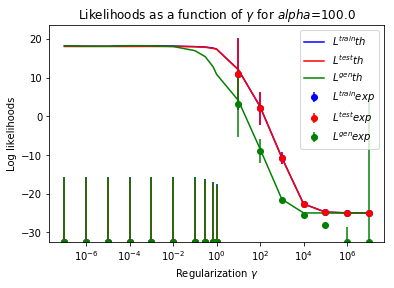

[-65.54348614 -65.46421223 -65.37681647 -65.65861652 -65.49608847
 -66.06102495 -68.26991433 -71.94018566 -78.07140288 -81.18190774
  10.94784319   2.09154761 -10.80022263 -22.66331593 -24.76215731
 -24.98238563 -24.99776176] [-65.61324748 -65.53397356 -65.44735619 -65.72801374 -65.56755104
 -66.13301191 -68.34629134 -72.01532795 -78.13553206 -81.24427134
  10.90877602   2.05492    -10.84078016 -22.67107656 -24.76267955
 -24.98263571 -24.99780207] [ -65.54348614  -65.46421223  -65.37684696  -65.65893455  -65.49929079
  -66.09278322  -68.57906802  -72.81493185  -79.91861712  -83.64996396
    3.05178278   -8.90911901  -21.67748041  -25.39598085  -28.05009784
  -54.65852407 -320.0866264 ]
[ 18.19777428  18.10327055  18.08871792  18.22540515  18.21010056
  18.15773348  17.98295832  17.89331775  17.62707364  17.34802837
  12.04184961   2.5008887  -10.68624688 -22.64447054 -24.76088667
 -24.97606586 -24.99760592] [ 18.02905053  18.02179246  18.02819844  18.0245314   18.03709188
  18.0240115 

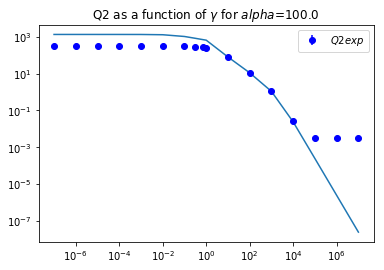

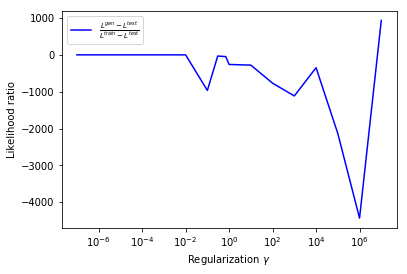

In [10]:
plot_likelihoods(base_exp='176492489e216d96', n_l=0, n_r=0)

In [ ]:
plot_likelihoods(base_exp='4491a251718f6a28', n_l=0, n_r=0)

In [127]:
def experiment_comparison_logZ(path='out_bidiag/', base_exp='048426a088a62f43'):
    siblings, values = get_siblings(base_exp, 'gamma', path=path)    
    with open(path+'raw/{}/params'.format(base_exp), 'r') as f:
        alpha = json.load(f)['alpha']
        
        
    siblings, values = siblings[2:], values[2:]
    print('Working with alpha = {}'.format(alpha))
    logZ_exp_mean = []
    logZ_exp_std = []
    logZ_the = []
    
    Q2_exp_mean = []
    Q2_exp_std = []
    Q2_the = []
    
    for folder, gamma in zip(siblings, values):
        print('Experiment with hash {} : gamma= {}'.format(folder, gamma))
#         logZ_exp_mean.append(np.load(path+'raw/{}/logZ_avg.npy'.format(folder))[-100:].mean())
#         logZ_exp_std.append(np.load(path+'raw/{}/logZ_std.npy'.format(folder))[-100:].mean())
        
        plop = compute_likelihoods(model_to_fit, alpha, gamma)[-2:]
    
        logZ_exp_mean.append(np.load(path+'raw/{}/logZ.npy'.format(folder))[:, -100:].mean())
        logZ_exp_std.append(np.load(path+'raw/{}/logZ.npy'.format(folder))[:, -100:].std())
        logZ_the.append(plop[0])
        print('LogZ Experiment : {} pm {}, theory : {}'.format(logZ_exp_mean[-1], logZ_exp_std[-1], logZ_the[-1]))
        
        Q2_exp_mean.append(np.load(path+'raw/{}/Q2.npy'.format(folder))[:, -100:].mean())
        Q2_exp_std.append(np.load(path+'raw/{}/Q2.npy'.format(folder))[:, -100:].std())
        Q2_the.append(plop[1])
        print('Q2 Experiment: {} pm {}, theory : {}'.format(Q2_exp_mean[-1], Q2_exp_std[-1], Q2_the[-1]))
        print('{} pm {}'.format(Q2_exp_mean[-1] / Q2_the[-1], Q2_exp_std[-1] / Q2_the[-1]))
        
    plt.figure()
    plt.errorbar(values, logZ_exp_mean, yerr=logZ_exp_std, label='Experiment')
    plt.errorbar(values, logZ_the, label='Theory')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Regularization $\gamma$')
    plt.ylabel(r'LogZ')
    plt.legend()
    plt.title(r'$logZ(\gamma)$ for fixed $\alpha$={}'.format(alpha))
    plt.show()
    
    plt.figure()
    plt.errorbar(values, Q2_exp_mean, yerr=Q2_exp_std, label='Experiment')
    plt.errorbar(values, Q2_the, label='Theory')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Regularization $\gamma$')
    plt.ylabel(r'Q2')
    plt.legend()
    plt.title(r'$Q2(\gamma)$ for fixed $\alpha$={}'.format(alpha))
    plt.show()


def experiment_comparison_mu(path='out_bidiag/', base_exp='048426a088a62f43'):
    siblings, values = get_siblings(base_exp, 'gamma', path=path)    
    with open(path+'raw/{}/params'.format(base_exp), 'r') as f:
        alpha = json.load(f)['alpha']
    
    print('Working with alpha = {}'.format(alpha))
    
    mu_exp_mean = []
    mu_exp_std = []
    mu_the = []
    
    for folder, gamma in zip(siblings, values):
        print('Experiment with hash {} : gamma= {}'.format(folder, gamma))
        mu_exp_mean.append(np.load(path+'raw/{}/mus.npy'.format(folder))[:, -100:].mean())
        mu_exp_std.append(np.load(path+'raw/{}/mus.npy'.format(folder))[:, -100:].std())
        
#         mu_exp_mean.append(np.load(path+'raw/{}/mu_avg.npy'.format(folder))[-100:].mean())
#         mu_exp_std.append(np.load(path+'raw/{}/mu_std.npy'.format(folder))[-100:].mean())
        
        mu_the.append(1)#solve_mu(model_to_fit, alpha, gamma))
        print('Experiment : {} pm {}, theory : {}'.format(mu_exp_mean[-1], mu_exp_std[-1], mu_the[-1]))
        
    plt.figure()
    plt.errorbar(values, mu_exp_mean, yerr=mu_exp_std, label='Experiment')
    plt.errorbar(values, mu_the, label='Theory')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Regularization $\gamma$')
    plt.ylabel(r'Lagrange multiplier $\mu$')
    plt.legend()
    plt.title(r'$\mu(\gamma)$ for fixed $\alpha$={}'.format(alpha))
    plt.show()

